## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [8]:
import itertools

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0728 15:47:09.853481 13408 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 15:47:09.854479 13408 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 15:47:09.862457 13408 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 15:47:09.969116 13408 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_defa

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3


W0728 15:47:10.185989 13408 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 15:47:10.193967 13408 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0728 15:47:10.276784 13408 deprecation.py:323] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 4s 77us/step - loss: 1.2635 - acc: 0.5613 - val_loss: 1.4829 - val_acc: 0.4747
Epoch 14/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.2417 - acc: 0.5706 - val_loss: 1.4774 - val_acc: 0.4767
Epoch 15/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.2223 - acc: 0.5752 - val_loss: 1.4629 - val_acc: 0.4834
Epoch 16/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.2041 - acc: 0.5830 - val_loss: 1.4663 - val_acc: 0.4828
Epoch 17/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.1845 - acc: 0.5896 - val_loss: 1.4572 - val_acc: 0.4821
Epoch 18/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.1664 - acc: 0.5971 - val_loss: 1.4618 - val_acc: 0.4819
Epoch 19/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.1474 - acc: 0.6045 - val_loss: 1.4586 - val_acc: 0.4845
Epoch 20/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 96us/step - loss: 2.2425 - acc: 0.2628 - val_loss: 2.1751 - val_acc: 0.3021
Epoch 2/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.7587 - acc: 0.3883 - val_loss: 1.7742 - val_acc: 0.3908
Epoch 3/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.6260 - acc: 0.4333 - val_loss: 1.6801 - val_acc: 0.4140
Epoch 4/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.5519 - acc: 0.4594 - val_loss: 1.6178 - val_acc: 0.4308
Epoch 5/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.4991 - acc: 0.4792 - val_loss: 1.5931 - val_acc: 0.4428
Epoch 6/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4550 - acc: 0.4939 - val_loss: 1.5721 - val_acc: 0.4463
Epoch 7/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.4179 - acc: 0.5066 - val_loss: 1.5414 - val_acc

50000/50000 [==============================] - 4s 78us/step - loss: 1.0622 - acc: 0.6356 - val_loss: 1.4597 - val_acc: 0.4906
Epoch 25/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.0459 - acc: 0.6449 - val_loss: 1.4514 - val_acc: 0.4977
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.2864 - acc: 0.5518 - val_loss: 1.4758 - val_acc: 0.4855
Epoch 13/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.2631 - acc: 0.5617 - val_loss: 1.4745 - val_acc: 0.4819
Epoch 14/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.2438 - acc: 0.5682 - val_loss: 1.4692 - val_acc: 0.4832
Epoch 15/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.2215 - acc: 0.5760 - val_loss: 1.4617 - val_acc: 0.4929
Epoch 16/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.2035 - acc: 0.5830 - val_loss: 1.4492 - val_acc: 0.4939
Epoch 17/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.1839 - acc: 0.5905 - val_loss: 1.4417 - val_acc: 0.4946
Epoch 18/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.1670 - acc: 0.5961 - val_loss: 1.4422 - val_acc: 0.4932
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 120us/step - loss: 2.7073 - acc: 0.1630 - val_loss: 2.7349 - val_acc: 0.1934
Epoch 2/25
50000/50000 [==============================] - 4s 87us/step - loss: 2.2773 - acc: 0.2491 - val_loss: 2.2578 - val_acc: 0.2662
Epoch 3/25
50000/50000 [==============================] - 4s 82us/step - loss: 2.1142 - acc: 0.2881 - val_loss: 2.1401 - val_acc: 0.2957
Epoch 4/25
50000/50000 [==============================] - 4s 82us/step - loss: 2.0183 - acc: 0.3137 - val_loss: 2.0680 - val_acc: 0.3072
Epoch 5/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.9524 - acc: 0.3300 - val_loss: 2.0038 - val_acc: 0.3220
Epoch 6/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.9018 - acc: 0.3464 - val_loss: 1.9543 - val_acc: 0.3336
Epoch 7/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.8619 - acc: 0.3582 - val_loss: 1.9191 - val_ac

Epoch 22/25
50000/50000 [==============================] - 5s 98us/step - loss: 0.5060 - acc: 0.8294 - val_loss: 2.0517 - val_acc: 0.4469
Epoch 23/25
50000/50000 [==============================] - 5s 99us/step - loss: 0.4771 - acc: 0.8392 - val_loss: 2.3286 - val_acc: 0.4239

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0009509901772253215.
Epoch 24/25
50000/50000 [==============================] - 5s 102us/step - loss: 0.4479 - acc: 0.8502 - val_loss: 2.0885 - val_acc: 0.4533
Epoch 25/25
50000/50000 [==============================] - 6s 126us/step - loss: 0.4165 - acc: 0.8625 - val_loss: 2.1256 - val_acc: 0.4645
Numbers of exp: 10, reduce_factor: 0.99, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)  

50000/50000 [==============================] - 6s 126us/step - loss: 1.2435 - acc: 0.5616 - val_loss: 1.5445 - val_acc: 0.4536
Epoch 8/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.2062 - acc: 0.5718 - val_loss: 1.5010 - val_acc: 0.4661
Epoch 9/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.1611 - acc: 0.5897 - val_loss: 1.4428 - val_acc: 0.4915
Epoch 10/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.1259 - acc: 0.6017 - val_loss: 1.4189 - val_acc: 0.5001
Epoch 11/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.0869 - acc: 0.6157 - val_loss: 1.6224 - val_acc: 0.4419
Epoch 12/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.0476 - acc: 0.6290 - val_loss: 1.5075 - val_acc: 0.4639
Epoch 13/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.0149 - acc: 0.6427 - val_loss: 1.5144 - val_acc: 0.4784
Epoch 14/25
50000/50000 [================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 207us/step - loss: 1.8772 - acc: 0.3558 - val_loss: 1.8492 - val_acc: 0.3712
Epoch 2/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.5446 - acc: 0.4579 - val_loss: 1.6967 - val_acc: 0.4173
Epoch 3/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.4466 - acc: 0.4921 - val_loss: 1.6099 - val_acc: 0.4292
Epoch 4/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.3802 - acc: 0.5176 - val_loss: 1.5207 - val_acc: 0.4648
Epoch 5/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.3261 - acc: 0.5378 - val_loss: 1.5646 - val_acc: 0.4534
Epoch 6/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.2840 - acc: 0.5524 - val_loss: 1.5185 - val_acc: 0.4667
Epoch 7/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.2494 - acc: 0.5650 - val_loss: 1.4803 -

50000/50000 [==============================] - 8s 156us/step - loss: 1.0922 - acc: 0.6279 - val_loss: 1.4496 - val_acc: 0.4926
Epoch 24/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.0795 - acc: 0.6340 - val_loss: 1.4460 - val_acc: 0.4906
Epoch 25/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.0696 - acc: 0.6372 - val_loss: 1.4532 - val_acc: 0.4938
Numbers of exp: 15, reduce_factor: 0.10, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_l

Epoch 10/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.8214 - acc: 0.3679 - val_loss: 1.8922 - val_acc: 0.3512
Epoch 11/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.8030 - acc: 0.3734 - val_loss: 1.8764 - val_acc: 0.3563
Epoch 12/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.7867 - acc: 0.3777 - val_loss: 1.8646 - val_acc: 0.3600
Epoch 13/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.7731 - acc: 0.3806 - val_loss: 1.8525 - val_acc: 0.3624
Epoch 14/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.7599 - acc: 0.3865 - val_loss: 1.8399 - val_acc: 0.3667
Epoch 15/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.7464 - acc: 0.3903 - val_loss: 1.8281 - val_acc: 0.3708
Epoch 16/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.7355 - acc: 0.3940 - val_loss: 1.8204 - val_acc: 0.3719
Epoch 17/25
50000/50000 [==

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 265us/step - loss: 1.8406 - acc: 0.3671 - val_loss: 2.3903 - val_acc: 0.3083
Epoch 2/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.5384 - acc: 0.4559 - val_loss: 2.6618 - val_acc: 0.2373
Epoch 3/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.4228 - acc: 0.4953 - val_loss: 1.9760 - val_acc: 0.3506
Epoch 4/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.3431 - acc: 0.5248 - val_loss: 2.7211 - val_acc: 0.2610
Epoch 5/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.2796 - acc: 0.5496 - val_loss: 1.9634 - val_acc: 0.3661
Epoch 6/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.2144 - acc: 0.5701 - val_loss: 1.9346 - val_acc: 0.3845
Epoch 7/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.1715 - acc: 0.5869 - val_loss: 2.1756 -

50000/50000 [==============================] - 7s 148us/step - loss: 0.7187 - acc: 0.7499 - val_loss: 1.8167 - val_acc: 0.4498
Epoch 21/25
50000/50000 [==============================] - 7s 145us/step - loss: 0.6873 - acc: 0.7635 - val_loss: 2.3195 - val_acc: 0.3842
Epoch 22/25
50000/50000 [==============================] - 7s 136us/step - loss: 0.6639 - acc: 0.7715 - val_loss: 1.8966 - val_acc: 0.4450

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0009320654743351042.
Epoch 23/25
50000/50000 [==============================] - 7s 147us/step - loss: 0.6318 - acc: 0.7833 - val_loss: 2.4439 - val_acc: 0.3961
Epoch 24/25
50000/50000 [==============================] - 7s 148us/step - loss: 0.6120 - acc: 0.7898 - val_loss: 1.8552 - val_acc: 0.4711
Epoch 25/25
50000/50000 [==============================] - 7s 130us/step - loss: 0.5848 - acc: 0.7981 - val_loss: 1.9260 - val_acc: 0.4623
Numbers of exp: 20, reduce_factor: 0.99, reduce_patient: 10
_____________________________________

50000/50000 [==============================] - 7s 150us/step - loss: 1.1457 - acc: 0.5983 - val_loss: 1.6324 - val_acc: 0.4272
Epoch 7/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.0964 - acc: 0.6165 - val_loss: 1.6551 - val_acc: 0.4188
Epoch 8/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.0564 - acc: 0.6295 - val_loss: 1.5485 - val_acc: 0.4561
Epoch 9/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.0163 - acc: 0.6464 - val_loss: 1.5529 - val_acc: 0.4495
Epoch 10/25
50000/50000 [==============================] - 7s 147us/step - loss: 0.9842 - acc: 0.6586 - val_loss: 1.4563 - val_acc: 0.4912
Epoch 11/25
50000/50000 [==============================] - 7s 145us/step - loss: 0.9502 - acc: 0.6716 - val_loss: 1.5798 - val_acc: 0.4618
Epoch 12/25
50000/50000 [==============================] - 7s 148us/step - loss: 0.9208 - acc: 0.6813 - val_loss: 1.4572 - val_acc: 0.4967
Epoch 13/25
50000/50000 [=================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 13s 266us/step - loss: 2.2972 - acc: 0.2440 - val_loss: 2.1375 - val_acc: 0.2995
Epoch 2/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.9391 - acc: 0.3372 - val_loss: 1.9969 - val_acc: 0.3275
Epoch 3/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.8028 - acc: 0.3774 - val_loss: 1.8536 - val_acc: 0.3672
Epoch 4/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.7168 - acc: 0.4031 - val_loss: 1.7859 - val_acc: 0.3898
Epoch 5/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.6544 - acc: 0.4254 - val_loss: 1.7338 - val_acc: 0.4037
Epoch 6/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.6060 - acc: 0.4403 - val_loss: 1.6904 - val_acc: 0.4164
Epoch 7/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.5663 - acc: 0.4531 - val_loss: 1.6689 -

Epoch 24/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.2257 - acc: 0.5765 - val_loss: 1.5040 - val_acc: 0.4759
Epoch 25/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.2125 - acc: 0.5820 - val_loss: 1.5010 - val_acc: 0.4750
Numbers of exp: 25, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

50000/50000 [==============================] - 8s 168us/step - loss: 1.4687 - acc: 0.4871 - val_loss: 1.6358 - val_acc: 0.4311
Epoch 12/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.4450 - acc: 0.4960 - val_loss: 1.6144 - val_acc: 0.4372
Epoch 13/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.4257 - acc: 0.5028 - val_loss: 1.6015 - val_acc: 0.4425
Epoch 14/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.4030 - acc: 0.5115 - val_loss: 1.5989 - val_acc: 0.4442
Epoch 15/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.3843 - acc: 0.5177 - val_loss: 1.5830 - val_acc: 0.4478
Epoch 16/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.3662 - acc: 0.5259 - val_loss: 1.5704 - val_acc: 0.4542
Epoch 17/25
50000/50000 [==============================] - 9s 176us/step - loss: 1.3477 - acc: 0.5301 - val_loss: 1.5802 - val_acc: 0.4506
Epoch 18/25
50000/50000 [==============

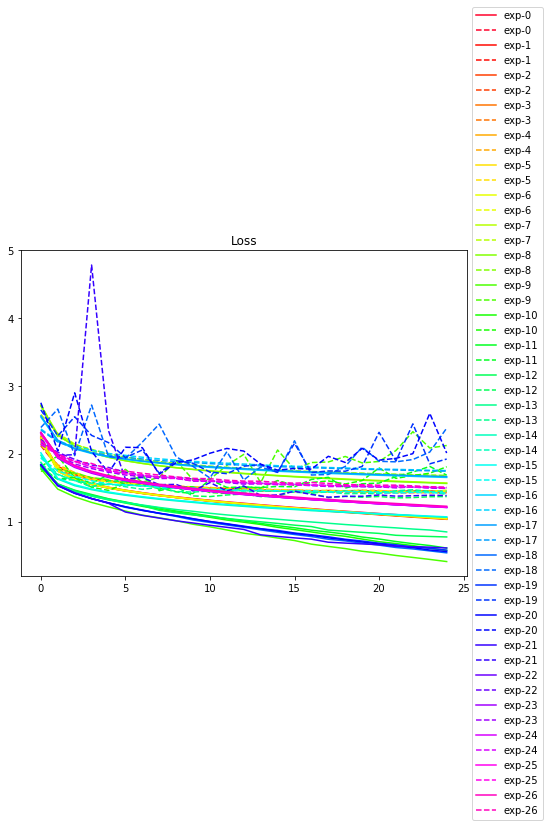

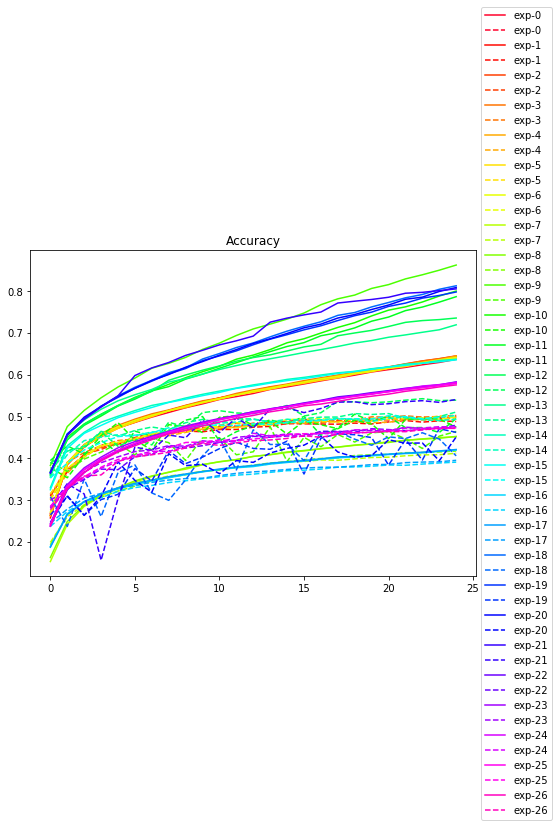

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()